### UNIVERSIDAD POLITECNICA SALESIANA
#### Alumno: Juan Cañar.
#### Docente: Ing. Diego Quisi


# Covid-19 infección en Ecuador. Modelos matemáticos y predicciones
Una comparación de modelos, lineal, polilnomico,logísticos y exponenciales aplicados a la infección por el virus Covid-19

Se realiza un análisis matemático simple del crecimiento de la infección en Python y dos modelos para comprender mejor la evolución de la infección.

Se crea modelos de series temporales del número total de personas infectadas hasta la fecha (es decir, las personas realmente infectadas más las personas que han sido infectadas). Estos modelos tienen parámetros , que se estimarán por ajuste de curva.

In [2]:
# Importar las librerias para el analasis
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline
from xml.dom import minidom

In [35]:
# Actualizar los datos (URL) 
#datos tomados de https://www.google.com/covid19/mobility/
#https://github.com/owid/covid-19-data/tree/master/public/data
#url = 'Libro1.xlsx'
url = 'owid-covid-data.csv'
df = pd.read_csv(url)
df= df.fillna(0)
df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,...,1803.987,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,...,1803.987,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,1803.987,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83,0.498
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,...,1803.987,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83,0.498
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,...,1803.987,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83,0.498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54602,0,0,International,2020-10-31,696.0,0.0,0.0,7.0,0.0,0.0,...,0.000,0.0,0.000,0.00,0.0,0.0,0.000,0.0,0.00,0.000
54603,0,0,International,2020-11-01,696.0,0.0,0.0,7.0,0.0,0.0,...,0.000,0.0,0.000,0.00,0.0,0.0,0.000,0.0,0.00,0.000
54604,0,0,International,2020-11-02,696.0,0.0,0.0,7.0,0.0,0.0,...,0.000,0.0,0.000,0.00,0.0,0.0,0.000,0.0,0.00,0.000
54605,0,0,International,2020-11-03,696.0,0.0,0.0,7.0,0.0,0.0,...,0.000,0.0,0.000,0.00,0.0,0.0,0.000,0.0,0.00,0.000


Imprimos los resultados y agregamos el numero del dia


In [36]:
df = df[df['location'].isin(['Ecuador'])] #Filtro la Informacion solo para Ecuador
df = df.loc[:,['date','total_cases','iso_code']] #Selecciono las columnas de analasis
# Expresar las fechas en numero de dias desde el 01 Enero
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)

df
#data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

,date,total_cases,iso_code
14568,-1,0.0,ECU
14569,0,0.0,ECU
14570,1,0.0,ECU
14571,2,0.0,ECU
14572,3,0.0,ECU
...,...,...,...
14873,304,167147.0,ECU
14874,305,168192.0,ECU
14875,306,169194.0,ECU
14876,307,169562.0,ECU


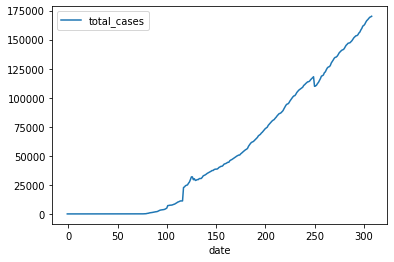

In [20]:
 df.plot(x ='date', y='total_cases')
#df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
#df['Ecuador']=df['Ecuador'].fillna(0) #Reemplaza con ceros 
#df = df.replace(np.nan, 1)
#df.describe()

Ahora podemos analizar los cuatro modelos que tomaré en el examen, que son la función lineal, polinomica,logística y la función exponencial . Cada modelo tiene tres parámetros , que se estimarán mediante un cálculo de ajuste de curva en los datos históricos.

## EL modelo lineal

La regresión lineal es un algoritmo de aprendizaje supervisado que se utiliza en Machine Learning y en estadística. En su versión más sencilla, lo que haremos es «dibujar una recta» que nos indicará la tendencia de un conjunto de datos continuos.

Recordemos rápidamente la fórmula de la recta:

Y = mX + b

Donde Y es el resultado, X es la variable, m la pendiente (o coeficiente) de la recta y b la constante o también conocida como el «punto de corte con el eje Y» en la gráfica (cuando X=0)
Ejemplo
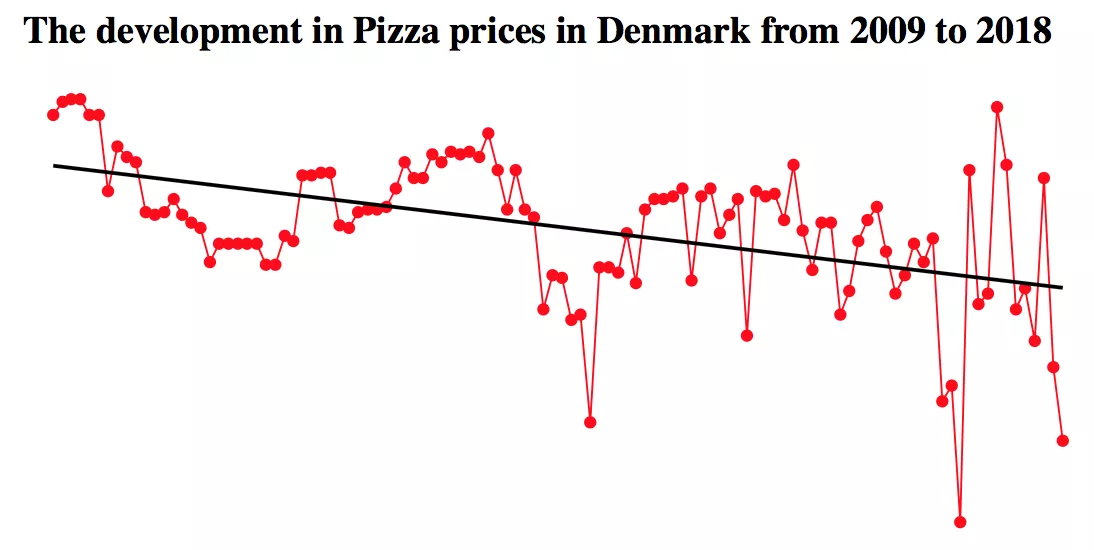

Recordemos que los algoritmos de Machine Learning Supervisados, aprenden por sí mismos y -en este caso- a obtener automáticamente esa «recta» que buscamos con la tendencia de predicción. Para hacerlo se mide el error con respecto a los puntos de entrada y el valor «Y» de salida real.



In [18]:
x = list(df.iloc [:, 0]) # Fecha
y = list(df.iloc [:, 1]) # Numero de casos
# Creamos el objeto de Regresión Lineal
regr = linear_model.LinearRegression()
print(x)
# Entrenamos nuestro modelo
regr.fit(np.array(x).reshape(-1, 1) ,y)

# Veamos los coeficienetes obtenidos, En nuestro caso, serán la Tangente
print('Coefficients: \n', regr.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Independent term: \n', regr.intercept_)
# Error Cuadrado Medio

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 

De la ecuación de la recta y = mX + b nuestra pendiente «m» es el coeficiente y el término independiente «b»


In [6]:
#Vamos a comprobar:
# Quiero predecir cuántos "Casos" voy a obtener por en el dia 100,
# según nuestro modelo, hacemos:
cantidad = int(input("ESCRIBA NUMERO DE DIAS: "))
y_prediccion = regr.predict([[cantidad]])
print('Para el dia',cantidad ,'hay estos casos: ',int(y_prediccion))

ESCRIBA NUMERO DE DIAS: 100
Para el dia 100 hay estos casos:  23705


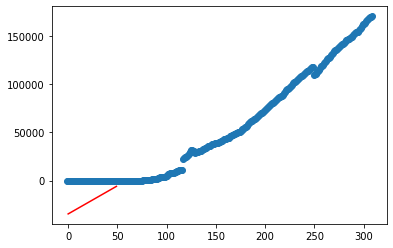

In [7]:
#Graficar
plt.scatter(x, y)
x_real = np.array(range(0, 50))
#print(x_real)
plt.plot(x_real, regr.predict(x_real.reshape(-1, 1)), color='red')
plt.show()



## El modelo logistico

El modelo logístico se ha utilizado ampliamente para describir el crecimiento de una población. Una infección puede describirse como el crecimiento de la población de un agente patógeno, por lo que un modelo logístico parece razonable .
La expresión más genérica de una función logística es:

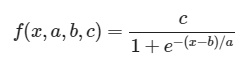

En esta fórmula, tenemos la variable x que es el tiempo y tres parámetros: a, b, c .

- a se refiere a la velocidad de infección
- b es el día en que ocurrieron las infecciones máximas
- c es el número total de personas infectadas registradas al final de la infección
 


A continuacion se puede apreciar un ejemplo de regresion logistica
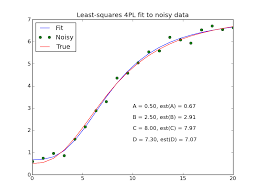

Definamos la función en Python y realicemos elprocedimiento de ajuste de curva utilizado para el crecimiento logístico.

In [52]:
def modelo_logistico(x,a,b):
    res=0
    if x[1] == 0:
        x=1
    else:
        res= a+b*np.log(x)
    return res

exp_fit = curve_fit(modelo_logistico,x,y) #Extraemos los valores de los paramatros
print(exp_fit)

(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))


## Graficas

TypeError: 'int' object is not subscriptable

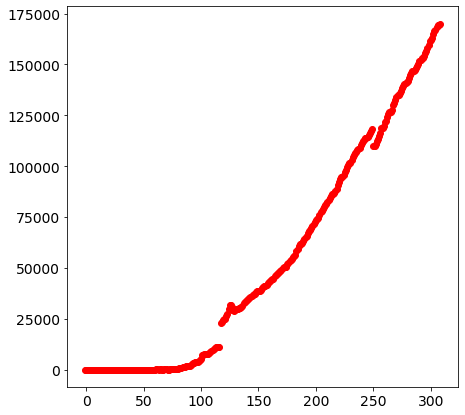

In [56]:
pred_x = list(range(min(x),max(x)+10)) # Predecir 50 dias mas
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
# Real data
plt.scatter(x,y,label="Datos Reales",color="red")
# Predicted exponential curve
plt.plot(pred_x, [modelo_logistico(i,exp_fit[0][0],exp_fit[0][1]) for i in pred_x], label="Modelo Logistico" )
plt.legend()
plt.xlabel("Desde el 1 Enero 2020")
plt.ylabel("Total de personas infectadas")
plt.ylim((min(y)*0.9,max(y)*3.1)) # Definir los limites de Y
plt.show()

## Modelo exponencial

Mientras que el modelo logístico describe un crecimiento de infección que se detendrá en el futuro, el modelo exponencial describe un crecimiento de infección imparable . Por ejemplo, si un paciente infecta a 2 pacientes por día, después de 1 día tendremos 2 infecciones, 4 después de 2 días, 8 después de 3 y así sucesivamente.
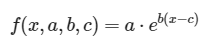

A continuacion se tiene un ejemplo de regresion exponencial
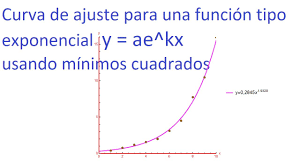

Predicción a 7 días sumando desde el ultimo día en x(30): -12989.85599420606 contagiados


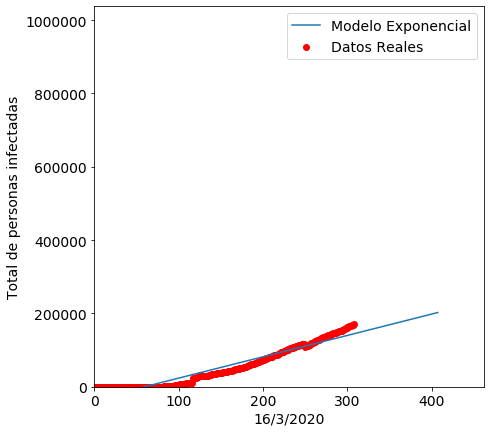

In [43]:
def modelo_exponencial(x,a,b):
    return a+b*np.exp(b*x)

exp_fit = curve_fit(modelo_exponencial,x,y)
#print(exp_fit)

pred_x = list(range(0,max(x)+100))
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)


plt.scatter(x,y,label="Datos Reales",color="red")
# Predicted exponential curve
puntos=[modelo_exponencial(i,exp_fit[0][0],exp_fit[0][1]) for i in pred_x]
print ('Predicción a 7 días sumando desde el ultimo día en x(30):', puntos[37], 'contagiados')
#print(x)

plt.plot(pred_x,puntos , label="Modelo Exponencial")
plt.legend()
plt.xlabel("16/3/2020")
plt.ylabel("Total de personas infectadas")
plt.ylim((0,max(y)*6.1))
plt.xlim((min(x)*0.9,max(x)*1.5))
plt.plot(37,puntos[37], 'oy')
plt.show()



## Modelo polinomial
Predicción de una variable de respuesta cuantitativa a partir de una variable predictora cuantitativa, donde la relación se modela como una función polinomial de orden n (esto significa que pueden tener de diferentes exponenciales o grados y se debe ir probando)  

Se puede tener una ecuacion con diferentes grados

y = a0 + a1x + a2x^2 + a3x^3 + … + anx^n + ε

Ejemplo de una regresion polinomica de grado 4.
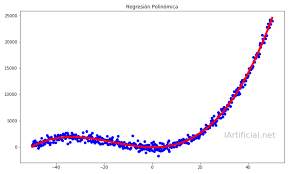


## Deber

In [136]:
# Implementar
filtro = df["Ecuador"][:] # Filtro los datos que se empezo a tener casos
#Obtenemos la mediana
print(filtro)
media = filtro.mean()
mediana = filtro.median()
print(mediana)
print(media)

#Tratar de predecir que va a pasar la proxima semana. y el prox mes.



0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
        ...  
304    1394.0
305     845.0
306    1045.0
307    1002.0
308     368.0
Name: Ecuador, Length: 309, dtype: float64
462.0
557.7697368421053


In [138]:
url = 'https://covid.ourworldindata.org/data/ecdc/total_cases.csv'
df_t = pd.read_csv(url)
df_t = df_t.replace(np.nan, 0)
FMT = '%Y-%m-%d'
date = df_t['date']
df_t['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)
df_t = df_t.loc[:,['date','Ecuador']] #Selecciono las columnas de analasis
y = list(df_t.iloc [:, 1]) # Total casos
x = list(df_t.iloc [:, 0]) # Dias
#Realizamos un ejemplo de prediccion
prediccion_siguiente = int(y[-1] + mediana)

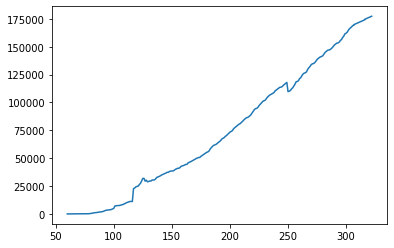

cuantos contagiados mas: 177423


In [140]:
# Quiero predecir cuántos "Casos" voy a obtener de aqui a 7 dias.
for i in range(x[-1], x[-1]+7):
    x.append(i)
    y.append(int(y[-1] + mediana))
plt.plot(x[61:], y[61:])
plt.show()

print('cuantos contagiados mas:',y[-1]+7)

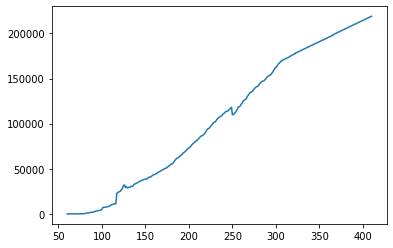

cuantos contagiados mas: 219041


In [143]:
# Quiero predecir cuántos "Casos" voy a obtener de aqui a 45 dias.
for i in range(x[-1], x[-1]+45):
    x.append(i)
    y.append(int(y[-1] + mediana))
plt.plot(x[61:], y[61:])
plt.show()

print('cuantos contagiados mas:',y[-1]+45)

### Numero de infectados menos el numero de recuperados.
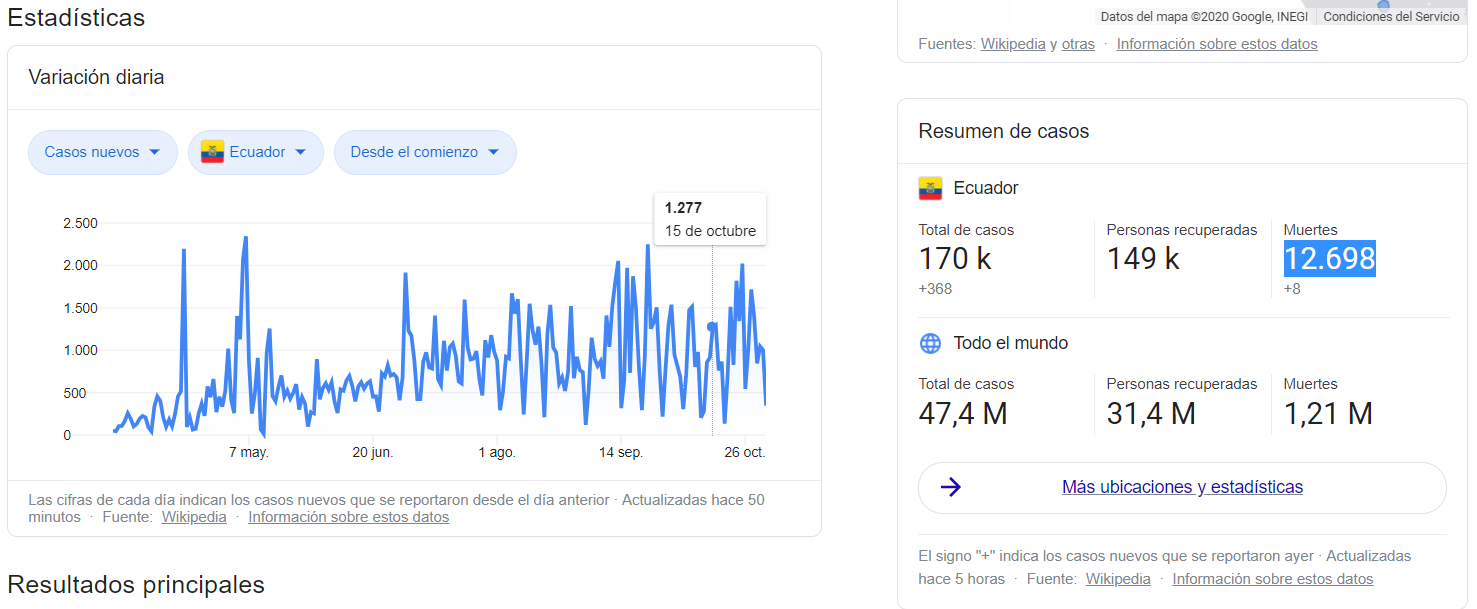

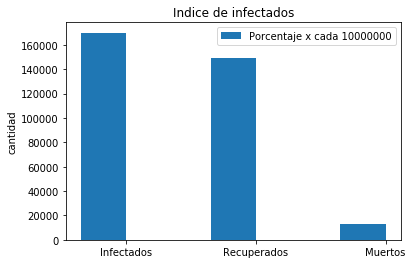

In [175]:
labels = ['Infectados', 'Recuperados', 'Muertos']
men_means = [170000,149000,12698]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Porcentaje x cada 10000000')
#rects2 = ax.bar(x + width/2, women_means, width, label='Mujer')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('cantidad')
ax.set_title('Indice de infectados')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

## Analisis

## Conclusiones
---
Como conclusion se puede decir que estos modelos matematicos son herramientas que nos ayudan a simular o predecir en un futuro los eventos que pasaran, aunque cabe recalcar que estos modelos son bastante subjetivos, lo que podria no acertar en su totalidad los eventos, pero si nos podria dar una referencia intermedia para poder tener un concepto claro, de como va ha afectarnos o que probabilidades existen de incremento o decremento.

---
## Criterio personal (politico, economico y  social de la situacion)

El ambito politico frente al covid juega un papel muy importante, ya que un buen manejo de los recursos del pais, puede dar una pronta respuesta a la pandemia mediante un buen manejo de entidades de salud y una buena planificacion, esto de cierta forma ayudaria a reducir los contagios y a manejar de mejor manera, ya que en pleno rebrote fuimos uno de los paises latinoamericanos mas afectado y con un alto indice de mortalidad como consecuencia del mal manejo y de la descarada corrupcion que existe, en cuanto a lo economico, es una etapa bastante dificil para el pais y su comunidad, debido a que la tasa de subempleo incrementa y tambien existen reduccion en la nomida de empleados, lo que trae consigo como consecuencia, que las personas no tengan dinero para mantenerse, tampoco puden acceder a la canasta basica, que desencadena en varios factores tales como desnutricion, enfermedades, personas sin hogar por la falta de posibilidades economicas, otros buscan obtener ingresos mediante microemprendimientos, para aliviar de cierta forma este problema, y en lo social haciendo referencia a puntos mencionados anteriormente se puede decir que afecta a todas las personas, en distintos ambitos tales como empleo, ingresos, comercios, salud, vivieda.

# Referencias

- https://www.researchgate.net/publication/340092755_Infeccion_del_Covid-19_en_Colombia_Una_comparacion_de_modelos_logisticos_y_exponenciales_aplicados_a_la_infeccion_por_el_virus_en_Colombia

- https://www.aprendemachinelearning.com/regresion-lineal-en-espanol-con-python/

- https://ourworldindata.org/coronavirus-data

- https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-codebook.csv